In [7]:
import pandas as pd
from collections import defaultdict
import numpy as np
from tqdm import tqdm

In [9]:
trainTask34 = pd.read_csv("../data/train_data/train_task_3_4.csv")
trainTask34.head()

,QuestionId,UserId,AnswerId,IsCorrect,CorrectAnswer,AnswerValue
0,898,2111,280203,1,2,2
1,767,3062,55638,1,3,3
2,165,1156,386475,1,2,2
3,490,1653,997498,1,4,4
4,298,3912,578636,1,3,3


In [28]:
qaResultDF = pd.DataFrame()
qaResultDict = defaultdict(lambda :defaultdict(int))
for i, line in tqdm(trainTask34.iterrows()):
    qaResultDict[line['QuestionId']]['Answer'] = line['CorrectAnswer']
    qaResultDict[line['QuestionId']]['Answered'] += 1
    qaResultDict[line['QuestionId']]['Correct'] += line['IsCorrect']
    qaResultDict[line['QuestionId']]['Select'+str(line['AnswerValue'])] += 1

1382727it [00:44, 31242.86it/s]


In [29]:
print(len(qaResultDict))
qaResultDF = pd.DataFrame(qaResultDict)
qaResultDF = qaResultDF.T
qaResultDF = qaResultDF.sort_index()
qaResultDF = qaResultDF.fillna(0)
qaResultDF = qaResultDF.astype('int64')

948


In [30]:
qaResultDF.head()

,Answer,Answered,Correct,Select2,Select4,Select3,Select1
0,1,2812,1247,986,252,327,1247
1,3,14,8,5,1,8,0
2,2,2313,891,891,355,521,546
3,2,2672,2161,2161,186,194,131
4,3,1704,684,301,414,684,305


In [31]:
from PIL import Image
import pytesseract
from nltk.tokenize import word_tokenize
from tqdm import tqdm
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/minjae/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [33]:
textLength = []
wordCount = []
avgWordLength = []
for i in tqdm(range(len(qaResultDF))):
    strInImage = pytesseract.image_to_string(Image.open(f'../data/images/{i}.jpg'))
    tokens = word_tokenize(strInImage)
    words = [word.lower() for word in tokens if word.isalpha()]
    text_length = len(strInImage)
    word_count = len(words)
    avg_word_length = 0 if word_count == 0 else text_length / word_count
    textLength.append(text_length)
    wordCount.append(word_count)
    avgWordLength.append(avg_word_length)

100%|██████████| 948/948 [02:16<00:00,  6.97it/s]


In [34]:
qaResultDF['TextLength'] = textLength
qaResultDF['WordCount'] = wordCount
qaResultDF['AvgWordLength'] = avgWordLength

In [58]:
AnswerRate = []
Entropy = []
for __, row in qaResultDF.iterrows():
    selections = []
    for i in range(1,5):
        if i == row['Answer']:
            continue
        selections.append(eval(f"row['Select{i}']/row['Answered']"))
    Entropy.append(-np.sum(list(map(lambda x: 0 if x == 0 else x*np.log2(x), selections))))
    AnswerRate.append(row['Correct']/row['Answered'])
qaResultDF['AnswerRate'] = AnswerRate
qaResultDF['Entropy'] = Entropy

In [59]:
qaResultDF.head()

,Answer,Answered,Correct,Select2,Select4,Select3,Select1,TextLength,WordCount,AvgWordLength,AnswerRate,Entropy
0,1,2812,1247,986,252,327,1247,143,24,5.958333,0.443457,1.203001
1,3,14,8,5,1,8,0,50,5,10.000000,0.571429,0.802464
2,2,2313,891,891,355,521,546,101,8,12.625000,0.385214,1.391026
3,2,2672,2161,2161,186,194,131,32,6,5.333333,0.808757,0.755624
4,3,1704,684,301,414,684,305,138,23,6.000000,0.401408,1.381994


In [60]:
qaResultDF.to_csv('qaResultDF.csv')

# Train Test data

In [61]:
questionDataTrain = qaResultDF[['TextLength','WordCount','AvgWordLength','AnswerRate','Entropy']]

In [62]:
questionDataTrain = questionDataTrain.reset_index()
questionDataTrain.rename(columns={'index':'qNum'}, inplace=True)
questionDataTrain['T1'] = np.nan
questionDataTrain['T2'] = np.nan
questionDataTrain['T3'] = np.nan
questionDataTrain['T4'] = np.nan
questionDataTrain['T5'] = np.nan

In [63]:
questionDataTrain.head()

,qNum,TextLength,WordCount,AvgWordLength,AnswerRate,Entropy,T1,T2,T3,T4,T5
0,0,143,24,5.958333,0.443457,1.203001,NaN,NaN,NaN,NaN,NaN
1,1,50,5,10.000000,0.571429,0.802464,NaN,NaN,NaN,NaN,NaN
2,2,101,8,12.625000,0.385214,1.391026,NaN,NaN,NaN,NaN,NaN
3,3,32,6,5.333333,0.808757,0.755624,NaN,NaN,NaN,NaN,NaN
4,4,138,23,6.000000,0.401408,1.381994,NaN,NaN,NaN,NaN,NaN


In [64]:
questionDataTest = questionDataTrain.copy()

## quality_response_remapped_public.csv

In [65]:
qualityResponsePublic = pd.read_csv('../data/test_data/quality_response_remapped_public.csv')

In [66]:
del qualityResponsePublic['Unnamed: 0.1']
del qualityResponsePublic['Unnamed: 0']
qualityResponsePublic = qualityResponsePublic.astype('Int64')

In [67]:
qualityResponsePublic.head()

,left,right,T1_ALR,T2_CL,T3_GF,T4_MQ,T5_NS
0,909,318,2,2,2,1,2
1,285,609,2,2,2,2,2
2,132,271,1,2,2,2,1
3,704,127,2,2,1,2,2
4,16,586,1,1,2,2,2


In [68]:
for __, row in qualityResponsePublic.iterrows():
    for i, expert in enumerate(row[2:]):
        if expert == 1:
            questionDataTrain.loc[row['left'],f'T{i+1}'] = 1
            questionDataTrain.loc[row['right'],f'T{i+1}'] = 0
        elif expert == 2:
            questionDataTrain.loc[row['left'],f'T{i+1}'] = 0
            questionDataTrain.loc[row['right'],f'T{i+1}'] = 1

In [69]:
questionDataTrain.dropna().head()

,qNum,TextLength,WordCount,AvgWordLength,AnswerRate,Entropy,T1,T2,T3,T4,T5
4,4,138,23,6.000000,0.401408,1.381994,1.0,1.0,1.0,0.0,0.0
16,16,77,11,7.000000,0.583478,1.119654,1.0,1.0,0.0,0.0,0.0
27,27,0,0,0.000000,0.451696,1.328048,1.0,1.0,0.0,1.0,0.0
56,56,95,16,5.937500,0.516450,1.194283,0.0,1.0,0.0,0.0,0.0
116,116,100,17,5.882353,0.532516,1.138286,0.0,0.0,0.0,0.0,0.0


In [70]:
(questionDataTrain.dropna()).to_csv('questionDataTrain.csv')

## quality_response_remapped_private.csv

In [71]:
qualityResponsePrivate = pd.read_csv('../data/test_data/quality_response_remapped_private.csv')

In [72]:
del qualityResponsePrivate['Unnamed: 0.1']
del qualityResponsePrivate['Unnamed: 0']
qualityResponsePrivate = qualityResponsePrivate.astype('Int64')

In [73]:
qualityResponsePrivate.head()

,left,right,T1_ALR,T2_CL,T3_GF,T4_MQ,T5_NS
0,145,762,2,2,2,2,2
1,307,208,1,1,1,2,1
2,278,195,1,1,1,1,1
3,13,153,2,2,2,2,2
4,23,100,2,1,1,1,1


In [74]:
qualityResponsePrivate = qualityResponsePrivate.dropna()

In [75]:
for i, row in qualityResponsePrivate.iterrows():
    for i, expert in enumerate(row[2:]):
        if expert == 1:
            questionDataTest.loc[row['left'],f'T{i+1}'] = 1
            questionDataTest.loc[row['right'],f'T{i+1}'] = 0
        elif expert == 2:
            questionDataTest.loc[row['left'],f'T{i+1}'] = 0
            questionDataTest.loc[row['right'],f'T{i+1}'] = 1

In [76]:
questionDataTest.dropna().head()

,qNum,TextLength,WordCount,AvgWordLength,AnswerRate,Entropy,T1,T2,T3,T4,T5
13,13,33,7,4.714286,0.696585,0.959276,0.0,0.0,0.0,0.0,0.0
23,23,114,17,6.705882,0.449050,1.333540,0.0,1.0,1.0,1.0,1.0
72,72,83,14,5.928571,0.534785,1.113530,1.0,1.0,0.0,1.0,1.0
74,74,56,10,5.600000,0.486194,1.259191,0.0,0.0,0.0,0.0,0.0
95,95,122,19,6.421053,0.384439,1.390804,0.0,0.0,0.0,1.0,1.0


In [77]:
(questionDataTest.dropna()).to_csv('questionDataTest.csv')

## ETC

In [ ]:
import matplotlib.pyplot as plt

''

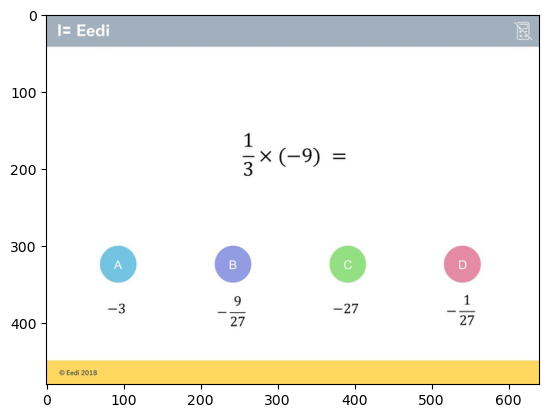

In [ ]:
i = 27
plt.imshow(np.asarray(Image.open(f'./data/images/{i}.jpg')))
Image.open(f'./data/images/{i}.jpg')
strInImage = pytesseract.image_to_string(Image.open(f'./data/images/{i}.jpg'))
strInImage